In [340]:
%pip install cvxopt

import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
import cvxopt

# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Repo root already in sys.path.


In [341]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    data = data[['Close']]
    data.dropna(inplace=True)
    return data

def simple_moving_average(data, window=15):
    df = data.copy()
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def exponential_moving_average(data, span=20):
    df = data.copy()
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
    return df


def relative_strength_index_ema(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.ewm(window,adjust=False).mean()
    avg_loss = down.ewm(window,adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_ema'] = 100 - (100 / (1 + rs))
    return df

def relative_strength_index_sma(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_sma'] = 100 - (100 / (1 + rs))
    return df


def bollinger_bands(data):
    df = data.copy()
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std
    return df

def macd_ewm(data):
    df = data.copy()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


def daily_return(data):
    df= data.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    return df

def rolling_volatility(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()
    return df

def lagged_returns(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Daily_Return'].shift(1)
    df['Lag_2'] = df['Daily_Return'].shift(2)
    df['Lag_3'] = df['Daily_Return'].shift(3)
    return df

def compute_technical_indicators(data):
    df = data.copy()
    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

In [342]:
data = fetch_data('SPY', '2015-01-01', '2025-07-08')
data = simple_moving_average(data, window=15)
#data = exponential_moving_average(data, span=20)
#data = relative_strength_index_ema(data, window=14)
#data = relative_strength_index_sma(data, window=14)
#data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
#data = rolling_volatility(data)
#data = lagged_returns(data)
#data = compute_technical_indicators(data)

C:\Users\Micha\AppData\Local\Temp\ipykernel_14508\24724489.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [343]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'].shift(-1) > 0, 1, -1)
data = data.dropna()
data = data.drop(columns=['Close','Daily_Return'])  
data


Price,SMA_15,MACD,MACD_Signal,Daily_Return_Sign
Ticker,,,,
Date,,,,
2015-01-23,169.364870,-0.310005,-0.584999,1
2015-01-26,169.365985,-0.145873,-0.497173,-1
2015-01-27,169.422778,-0.196163,-0.436971,-1
2015-01-28,169.440597,-0.406547,-0.430886,1
2015-01-29,169.422777,-0.443497,-0.433408,-1
...,...,...,...,...
2025-06-30,602.754956,8.552787,7.697283,-1
2025-07-01,604.070797,8.883796,7.934586,1


In [344]:
def train_test_split(
    df,
    training_data_fraction=0.8,
    class_column_name='Class',
    shuffle=True,
    return_numpy=True
):
    """
    Split DataFrame into X/Y and train/test safely.

    Ensures the label is excluded from X using .drop(),
    so it cannot silently leak into the features.

    Parameters:
        df: DataFrame
            Your full data with features + label column.
        training_data_fraction: float
            Fraction to use for training set (0 < fraction < 1).
        class_column_name: str
            Name of the label column.
        shuffle: bool
            Whether to shuffle the rows.
        return_numpy: bool
            If True, returns arrays; else DataFrames.

    Returns:
        X, Y, X_train, Y_train, X_test, Y_test
    """

    # Make sure the label column exists
    assert class_column_name in df.columns, \
        f"Label column '{class_column_name}' not found in DataFrame!"

    # Shuffle or not
    if shuffle:
        df_ = df.sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        df_ = df.copy()

    # Split index
    split_idx = int(training_data_fraction * len(df_))
    train_df = df_.iloc[:split_idx, :]
    test_df = df_.iloc[split_idx:, :]

    # Safe feature-label split using .drop()
    X = df_.drop(columns=[class_column_name])
    Y = df_[class_column_name]

    X_train = train_df.drop(columns=[class_column_name])
    Y_train = train_df[class_column_name]

    X_test = test_df.drop(columns=[class_column_name])
    Y_test = test_df[class_column_name]

    # Sanity check: does X contain Y?
    if np.allclose(X.iloc[:, -1], Y):
        raise ValueError("Last column of X is identical to Y! Possible leakage.")

    if return_numpy:
        return (
            X.to_numpy(), Y.to_numpy(),
            X_train.to_numpy(), Y_train.to_numpy(),
            X_test.to_numpy(), Y_test.to_numpy()
        )
    else:
        return X, Y, X_train, Y_train, X_test, Y_test


In [345]:
from courselib.utils.normalization import standardize
training_data_fraction = .5
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign',shuffle = False,return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)

In [346]:
from courselib.models.svm import LinearSVM
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=0.5)
metrics_history = svm.fit(X_train,Y_train, num_epochs = 5000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [347]:
svm.w, svm.b

(array([-0.00304603,  0.00022596,  0.00125644]), array(0.0197431))

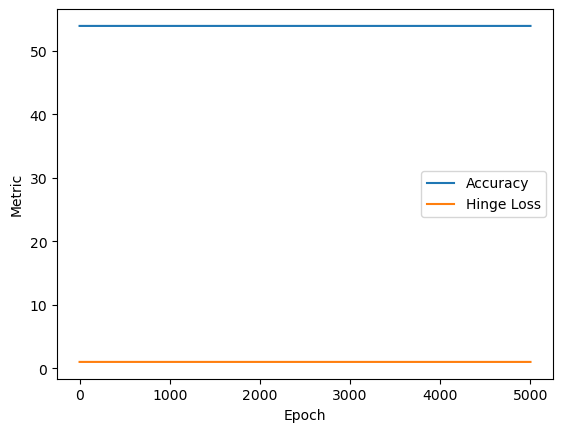

In [348]:
import matplotlib.pyplot as plt

plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()


In [349]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 58.174904942965775


In [350]:
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].replace({-1: 0})
data

Price,SMA_15,MACD,MACD_Signal,Daily_Return_Sign
Ticker,,,,
Date,,,,
2015-01-23,169.364870,-0.310005,-0.584999,1
2015-01-26,169.365985,-0.145873,-0.497173,0
2015-01-27,169.422778,-0.196163,-0.436971,0
2015-01-28,169.440597,-0.406547,-0.430886,1
2015-01-29,169.422777,-0.443497,-0.433408,0
...,...,...,...,...
2025-06-30,602.754956,8.552787,7.697283,0
2025-07-01,604.070797,8.883796,7.934586,1


In [ ]:
from courselib.models.glm import LogisticRegression
from courselib.utils.metrics import cross_entropy
training_data_fraction = .8
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign', shuffle=False, return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)
logistic_regression.w, logistic_regression.b

(array([-0.02815826, -0.00274225,  0.01350844]), array(0.11274067))

In [352]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 58.174904942965775


In [353]:
# Trading Strategy

# Example DataFrame
data = {
    'price': [100, 102, 101, 105, 107, 106],
    'signal': [1, 1, 1, 0, 0, 1]
}

df = pd.DataFrame(data)

# 1. Compute daily asset returns
df['return'] = df['price'].pct_change()

# 2. Shift the signal if needed (optional)
# You might want to execute the trade next day, so shift by 1
df['signal_shifted'] = df['signal'].shift(-1)

# 3. Strategy daily return: asset return * signal
df['strategy_return'] = df['return'] * df['signal_shifted']

# 4. Cumulative returns
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_asset'] = (1 + df['return']).cumprod()

print(df)


   price  signal    return  signal_shifted  strategy_return  \
0    100       1       NaN             1.0              NaN   
1    102       1  0.020000             1.0         0.020000   
2    101       1 -0.009804             0.0        -0.000000   
3    105       0  0.039604             0.0         0.000000   
4    107       0  0.019048             1.0         0.019048   
5    106       1 -0.009346             NaN              NaN   

   cumulative_strategy  cumulative_asset  
0                  NaN               NaN  
1             1.020000              1.02  
2             1.020000              1.01  
3             1.020000              1.05  
4             1.039429              1.07  
5                  NaN              1.06  


In [354]:

def pca_numpy(X: np.ndarray, n_components: int = 2):
    """
    Perform PCA using numpy.

    Parameters:
    -----------
    X : np.ndarray
        The input data matrix, shape (n_samples, n_features).
    n_components : int
        Number of principal components to keep.

    Returns:
    --------
    X_reduced : np.ndarray
        The projected data onto top principal components.
    explained_variance_ratio : np.ndarray
        Percentage of variance explained by each selected component.
    components : np.ndarray
        The eigenvectors (principal axes).
    """
    # 1) Center the data
    X_meaned = X - np.mean(X, axis=0)

    # 2) Covariance matrix
    cov_mat = np.cov(X_meaned, rowvar=False)

    # 3) Eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    # 4) Sort eigenvalues and eigenvectors in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_index]
    eigen_vectors = eigen_vectors[:, sorted_index]

    # 5) Select top k eigenvectors
    eigenvector_subset = eigen_vectors[:, 0:n_components]

    # 6) Project the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # 7) Explained variance ratio
    explained_variance_ratio = eigen_values / np.sum(eigen_values)

    return X_reduced, explained_variance_ratio[:n_components], eigenvector_subset


In [355]:
X_reduced, explained_var, components = pca_numpy(X, n_components=5)
X_reduced, explained_var, components

(array([[ 0.92528179,  1.02990719, -0.05258454],
        [ 0.87861039,  1.04318342, -0.06552239],
        [ 0.87583266,  1.04309167, -0.04395708],
        ...,
        [-3.44841902, -1.36587101, -0.12882046],
        [-3.6213784 , -1.33098747, -0.17152381],
        [-3.66948094, -1.32894602, -0.11445589]]),
 array([0.67578471, 0.30667634, 0.01753895]),
 array([[-0.26919474, -0.96292282, -0.01771549],
        [-0.67945878,  0.20292159, -0.70509474],
        [-0.68254667,  0.17777085,  0.70889179]]))